In [1]:
import glob
import os
import json
import numpy as np
import seaborn as sns
import pandas as pd

from pipeline.python.classifications import linearSVC_class as lsvc

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/combine_runs.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [212]:
import pylab as pl
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter


In [2]:
%matplotlib notebook

#### Set data source

In [256]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC026'
session = '20181207' #'20181209'
fov = 'FOV1_zoom2p0x'
run = 'combined_blobs_static'
traceid = 'traces001'

traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run, 'traces', '%s*' % traceid))[0]
data_fpath = os.path.join(traceid_dir, 'data_arrays', 'datasets.npz')


In [218]:
class struct():
    pass

class DataSet():
    
    def __init__(self, animalid='RATID', session='YYYYMMDD', fov='FOV1_zoom1p0x', run='experiment_run1', 
                 traceid='traces00x', rootdir='/n/coxfs01/2p-data'):
        self.rootdir=rootdir
        self.animalid = animalid
        self.session = session
        self.fov = fov
        self.run = run
        self.traceid = traceid
        self.source = glob.glob(os.path.join(rootdir, animalid, session,'%s*' % fov, run, 'traces', '%s*' % traceid, 'data_arrays', 'datasets.npz'))[0]
        
        self.data_identifier = '_'.join((animalid, session, fov, run, traceid))

        self.datasets = {}
    

    def load_dataset(self, roi_selector='visual', visual_area='visual_area_name', segmented_areas_fpath=None):
        
        print "------------ Loading dataset."
        # Store DATASET:            
        dt = np.load(self.source)
        if 'arr_0' in dt.keys():
            dataset = dt['arr_0'][()]
        else:
            dataset = dt           

        # Store run info:
        if isinstance(dataset['run_info'], dict):
            run_info = dataset['run_info']
        else:
            run_info = dataset['run_info'][()]
        
        # Store stim configs:
        if isinstance(dataset['sconfigs'], dict):
            orig_sconfigs = dataset['sconfigs']
        else:
            orig_sconfigs = dataset['sconfigs'][()]

        # Make sure numbers are rounded:
        for cname, cdict in orig_sconfigs.items():
            for stimkey, stimval in cdict.items():
                if isinstance(stimval, (int, float)):
                    orig_sconfigs[cname][stimkey] = round(stimval, 1)
                    
        # Add combined 'position' variable to stim configs:
        for cname, config in orig_sconfigs.items():
            pos = '_'.join([str(config['xpos']), str(config['ypos'])])
            orig_sconfigs[cname].update({'position': pos})
        
        # Correct for old naming scheme for morph levels:
        if int(self.session) < 20180602:
            # Rename morphs:
            update_configs = [cfg for cfg, info in orig_sconfigs.items() if info['morphlevel'] > 0]
            for cfg in update_configs:
                if orig_sconfigs[cfg]['morphlevel'] == 6:
                    orig_sconfigs[cfg]['morphlevel'] = 27
                elif orig_sconfigs[cfg]['morphlevel'] == 11:
                    orig_sconfigs[cfg]['morphlevel'] = 53
                elif orig_sconfigs[cfg]['morphlevel'] == 16:
                    orig_sconfigs[cfg]['morphlevel'] = 79
                elif orig_sconfigs[cfg]['morphlevel'] == 22:
                    orig_sconfigs[cfg]['morphlevel'] = 106
                else:
                    print "Unknown morphlevel converstion: %i" % orig_sconfigs[cfg]['morphlevel']
        
        # Make sure specified const_trans are actually tested transforms:
        sdf = pd.DataFrame(orig_sconfigs).T
#         id_preserving_transforms = ['xpos', 'ypos', 'size', 'yrot']
#         true_trans_dict = dict((tkey, list(set(sdf[tkey]))) for tkey in id_preserving_transforms)
#         varying_transforms = [t for t,vals in true_trans_dict.items() if len(vals) > 1]
    
        visual_areas_fpath=''; included_rois=None; areas=None;
        if segmented_areas_fpath is not None:
            print "Getting ROIs for area: %s" % visual_area
            print "Loading file:", segmented_areas_fpath
            with open(segmented_areas_fpath, 'rb') as f:
                areas = pkl.load(f)
            if visual_area not in areas.regions.keys():
                print "Specified visual area - %s - NOT FOUND."
                for vi, va in enumerate(areas.regions.keys()):
                    print vi, va
                sel = input("Select IDX of area to use: ")
                visual_area = areas.regions.keys()[sel]
            included_rois = [int(ri) for ri in areas.regions[visual_area]['included_rois']]
        else:
            included_rois = None
        
        brain_region = {}
        brain_region['name'] = visual_area
        brain_region['source'] = segmented_areas_fpath
        brain_region['roi_indices'] = included_rois
        brain_region['segmentation'] = None if areas is None else areas.regions[visual_area]  
        
        self.update_data(dataset, sdf, run_info, brain_region, roi_selector=roi_selector)

    def load_roi_list(self, roi_selector='visual'):
        
        traceid_dir = glob.glob(os.path.join(self.rootdir, self.animalid, self.session, '%s*' % self.fov, run, 'traces', '%s*' % self.traceid))[0]
        
        if roi_selector == 'all':
            roi_list = None
        else:
            roistats_results_fpath = os.path.join(traceid_dir, 'sorted_rois', 'roistats_results.npz')
            roistats = np.load(roistats_results_fpath)

            roi_subset_type = 'sorted_%s' % roi_selector
            roi_list = roistats[roi_subset_type]

        return roi_list

    def update_data(self, dataset, sdf, run_info, brain_region, roi_selector='visual'):
        d = struct()
        
        # Get visual rois:
        visual_rois = self.load_roi_list(roi_selector=roi_selector)
        if visual_rois is None:
            visual_rois = np.arange(0, dataset['corrected'].shape[1])
    
        # Get subset of rois within specified visual area:
        rois_in_visual_area=None
        if brain_region['roi_indices'] is not None:
            rois_in_visual_area = np.array(brain_region['roi_indices'])
        
        # Get final roi indices:
        if rois_in_visual_area is not None:
            roi_indices = intersection(visual_rois, rois_in_visual_area)
        else:
            roi_indices = visual_rois.copy()
    
        # Get subset of roi traces specified:
        traces = dataset['corrected'][:, roi_indices]
        
        # Get labels dataframe (for traces):
        labels = pd.DataFrame(data=dataset['labels_data'], columns=dataset['labels_columns'])
        
        d.traces = traces
        d.labels = labels
        d.roi_indices = roi_indices
        d.conditions = sdf
        d.run_info = run_info
        d.brain_region = brain_region
        
        self.datasets.update({'%s' % brain_region['name']: d})
        

In [219]:
def get_formatted_data(xdata, labels, multiple_durs=True, data_type='stat', stat_type='meanstim', get_null=False): #get_training_data(self):
    '''
    Returns input data formatted as:
        ntrials x nrois (data_type=='stat')
        nframes x nrois (data_type = 'frames')
    Filters nrois by roi_selector.
    '''
    print "------------ Formatting data into samples."


    # Determine whether all trials have the same structure or not:
    multiple_durs = len(list(set(labels['nframes_on']))) > 1

    if data_type == 'stat':
        cX, cy = get_stat_samples(xdata, labels, multiple_durs=multiple_durs, stat_type=stat_type, get_null=get_null)
    else:
        cX, cy = get_frame_samples(xdata, labels, self.params)

    print "Ungrouped dataset cX:", cX.shape
    print "Ungrouped dataset labels cy:", cy.shape

    return cX, cy

In [466]:

def get_stat_samples(traces, labels, multiple_durs=True, stat_type='meanstim', get_null=False):
    ntrials_total = len(labels['trial'].unique())
    ntrials_per_cond = [len(t) for t in labels.groupby('config')['trial'].unique()]
    if len(np.unique(ntrials_per_cond)) > 1:
        print("***warning*** uneven reps per condition: %s" % str(np.unique(ntrials_per_cond)))
    #assert len(np.unique(ntrials_per_cond)) == 1, "Uneven reps per condition! %s" % str(ntrials_per_cond)
    ntrials = np.unique(ntrials_per_cond)[0]
    
    # Get baseline and stimulus indices for each trial:
    sample_labels = []
    stim_on_frame = labels['stim_on_frame'].unique()
    assert len(stim_on_frame) == 1, "More than 1 stim on frame found! %s" % str(stim_on_frame)
    stim_on_frame = stim_on_frame[0]
    if multiple_durs:
        tgroups = labels.groupby('trial')            
        std_baseline_values=[]; mean_baseline_values=[]; mean_stimulus_values=[];
        for k,g in tgroups:
            curr_nframes_on = g['nframes_on'].unique()[0]

            curr_baseline_stds = np.nanstd(traces[g['tsec'][0:stim_on_frame].index.tolist(), :], axis=0)
            curr_baseline_means = np.nanmean(traces[g['tsec'][0:stim_on_frame].index.tolist(), :], axis=0)

            curr_stimulus_means = np.nanmean(traces[g['tsec'][stim_on_frame:stim_on_frame+curr_nframes_on].index.tolist(), :], axis=0)
            
            std_baseline_values.append(curr_baseline_stds)
            mean_baseline_values.append(curr_baseline_means)
            mean_stimulus_values.append(curr_stimulus_means)
            
            curr_config = g['config'].unique()[0]
            sample_labels.append(curr_config)
        
        mean_stim_on_values = np.vstack(mean_stimulus_values)
        mean_baseline_values = np.vstack(mean_baseline_values)
        std_baseline_values = np.vstack(std_baseline_values)
        
    else:
        nrois = traces.shape[-1]
        nframes_per_trial = traces.shape[0] / ntrials_total
        assert len(labels['nframes_on'].unique()) == 1, "Uneven num frames stim ON: %s" % str(labels['nframes_on'].unique())
        nframes_on = labels['nframes_on'].unique()[0]
        
        tracemat = np.reshape(traces, (ntrials_total, nframes_per_trial, nrois), order='C')
        sample_labels = np.reshape(labels['config'].tolist(), (ntrials_total, nframes_per_trial), order='C')[:, 0]
        
        std_baseline_values = np.nanstd(tracemat[:, 0:stim_on_frame], axis=1)
        mean_baseline_values = np.nanmean(tracemat[:, 0:stim_on_frame], axis=1)
        mean_stim_on_values = np.nanmean(tracemat[:, stim_on_frame:stim_on_frame+nframes_on], axis=1)
            
    if stat_type == 'zscore':
        sample_array = (mean_stim_on_values - mean_baseline_values ) / std_baseline_values
    elif stat_type == 'meanstimdff':
        sample_array = (mean_stim_on_values - mean_baseline_values ) / mean_baseline_values
    else:
        sample_array = mean_stim_on_values.copy()
    
    if get_null:
        random_draw = True
        print "Stim values:", sample_array.shape
        if random_draw:
            selected_trial_ixs = random.sample(range(0, mean_baseline_values.shape[0]), ntrials)
        bas = mean_baseline_values[selected_trial_ixs, :]
    
        sample_array = np.append(sample_array, bas, axis=0)
        print "Added null cases:", sample_array.shape
        sample_labels.extend(['bas' for _ in range(bas.shape[0])])
    
    return sample_array, np.array(sample_labels)

# Create DataSet object:

In [221]:
roi_selector = 'visual'
data_type='stat'
stat_type='meanstim'
inputdata_type='corrected'
get_null=False

class_name='size'
class_subset=''
const_trans=''
trans_value=''
test_set=[]
indie=False

cv_method='kfold'
cv_nfolds=5
cv_ngroups=1
C_val=1e9

binsize=10
nprocesses=1
select_visual_area=False
visual_area='LI'


In [1377]:
# rootdir = '/n/coxfs01/2p-data'
# animalid = 'CE077' #'JC026'
# session = '20180521' #'20181209'
# fov = 'FOV1_zoom1x' #'FOV1_zoom2p0x'
# run = 'combined_blobs_static' #'combined_blobs_static'
# traceid = 'traces002' # 'traces001'

# rootdir = '/n/coxfs01/2p-data'
# animalid = 'JC026'
# session = '20191209' #'20181207' #'20181209'
# fov = 'FOV1_zoom2p0x'
# run = 'combined_gratings_static' #combined_blobs_static'
# traceid = 'traces001'

rootdir = '/n/coxfs01/2p-data'
animalid = 'JC031'
session = '20181118' #'20181207' #'20181209'
fov = 'FOV1_zoom2p0x'
run = 'combined_gratings_static' #combined_blobs_static'
traceid = 'traces001'


In [1378]:
visual_area = 'LI'
D = DataSet(animalid=animalid, session=session, fov=fov, run=run, traceid=traceid)


In [1379]:
D.load_dataset(roi_selector='visual', visual_area=visual_area, segmented_areas_fpath=None)
print D.datasets
print "%s: \n" % visual_area, dir(D.datasets[visual_area])

------------ Loading dataset.
{'LI': <__main__.struct instance at 0x7f51498725f0>}
LI: 
['__doc__', '__module__', 'brain_region', 'conditions', 'labels', 'roi_indices', 'run_info', 'traces']


In [1380]:
d = D.datasets[visual_area]
print "--- raw traces:", d.traces.shape
print "--- corresp. labels:", d.labels.shape
print "--- conditions dataframe:\n", d.conditions.head()

--- raw traces: (283200, 189)
--- corresp. labels: (283200, 6)
--- conditions dataframe:
          direction ori     position   sf size speed  stimtype xpos ypos
config001         0   0  -28.0_-15.0  0.1   17    10  gratings  -28  -15
config002         0   0   -28.0_-5.0  0.1   17    10  gratings  -28   -5
config003         0   0    -28.0_5.0  0.1   17    10  gratings  -28    5
config004         0   0   -28.0_15.0  0.1   17    10  gratings  -28   15
config005         0   0  -14.0_-15.0  0.1   17    10  gratings  -14  -15


In [1381]:

print("xpos:", list(set(d.conditions['xpos'])))
print("ypos:", list(set(d.conditions['ypos'])))
print("size:", list(set(d.conditions['size'])))
print d.run_info['trans_types']

('xpos:', [0.0, 28.0, -14.0, -28.0, 14.0])
('ypos:', [-15.0, -5.0, 5.0, 15.0])
('size:', [17.0])
['ori', 'xpos', 'ypos']


In [1382]:
sample_data, sample_labels = get_formatted_data(d.traces, d.labels)
print sample_data.shape
print sample_labels.shape
        

------------ Formatting data into samples.
Ungrouped dataset cX: (1600, 189)
Ungrouped dataset labels cy: (1600,)
(1600, 189)
(1600,)


In [1383]:
# # -------------------------------------------------------------------------
# # MODEL SELECTION PARAMS:
# feature_select_method='rfe' #'rfe' #'rfe'
# feature_select_n='best' #'best' #'best'
# C_select='big' #'best'
# # -------------------------------------------------------------------------

# # -------------------------------------------------------------------------
# # TRAINING PARAMS:
# scoring = 'accuracy'
# full_train = False
# test_size = 0.2 #0.33 #0.33 #0.20 #0.33 #0.33
# create_new = True

# m50 = 53
# m100 = 106 #106

# col_label = 'xpos' # 'xpos'
# row_label = 'ypos' #'ypos'

In [1384]:
def get_best_C(svc_in, cX, cy, output_dir=None, figname=None):
    # Look at cross-validation scores as a function of parameter C
    svc = copy.copy(svc_in)
    C_s = np.logspace(-10, 10, 50)
    scores = list()
    scores_std = list()
    for C in C_s:
        svc.C = C
        this_scores = cross_val_score(svc, cX, cy, n_jobs=1)
        scores.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))

    # Do the plotting
    pl.figure(figsize=(4,4))
    pl.semilogx(C_s, scores)
    pl.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
    pl.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
    locs, labels = pl.yticks()
    pl.yticks(locs, list(map(lambda x: "%g" % x, locs)))
    pl.ylabel('CV score')
    pl.xlabel('Parameter C')
    pl.ylim(0, 1.1)

    best_idx_C = scores.index(np.max(scores))
    best_C = C_s[best_idx_C]
    pl.title('best C: %0.4f' % best_C)

    if output_dir is not None:
        if figname is None:
            figname = 'crossval_scores_by_C.png'
        pl.savefig(os.path.join(output_dir, figname))
        pl.close()

    return best_C



In [1385]:

def plot_confusion_matrix(cmatrix, classes,
                          ax=None,
                          normalize=False,
                          title='Confusion matrix', clim=None,
                          cmap=pl.cm.Blues, cmin=0, cmax=1.0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        if clim=='max':
            cmax = cmatrix.max()
    else:
        print('Confusion matrix, without normalization')

    if ax is None:
        fig = pl.figure(figsize=(4,4))
        ax = fig.add_subplot(111)

    ax.set_title(title, fontsize=10)

    im = ax.imshow(cmatrix, interpolation='nearest', cmap=cmap, vmax=cmax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=8)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=8)
    fmt = '.1f' if normalize else 'd'
    thresh = cmatrix.max() #/ 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        ax.text(j, i, format(cmatrix[i, j], fmt),
                 horizontalalignment="center", fontsize=6,
                 color="white" if cmatrix[i, j] > thresh else "black")

    #pl.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(im, cax=cax)

    return ax

In [1386]:
def group_by_class(cX, cy, conditions, class_name='CLASS'):
    cy_tmp = cy.copy()
    cy = np.array([conditions.loc[cv][class_name] if cv != 'bas' else 'bas' for cv in cy_tmp])
    class_labels = sorted(list(set(cy))) 
    return cX, cy, class_labels

# Select train and test sets

In [1387]:
from sklearn.preprocessing import StandardScaler


In [1388]:
print("Transforms tested:", d.run_info['trans_types'])
transforms = {}
for trans in d.run_info['trans_types']:
    transforms[trans] = list(set(d.conditions[trans]))
transforms

('Transforms tested:', ['ori', 'xpos', 'ypos'])


{'ori': [0.0, 90.0, 180.0, 270.0],
 'xpos': [0.0, 28.0, -14.0, -28.0, 14.0],
 'ypos': [-15.0, -5.0, 5.0, 15.0]}

Train data: (640, 83)
Train labels: ['-14.0_5.0', '14.0_5.0']


<IPython.core.display.Javascript object>


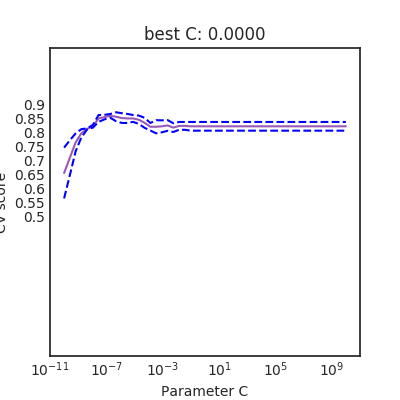

N features 54 54 (83,)


<IPython.core.display.Javascript object>


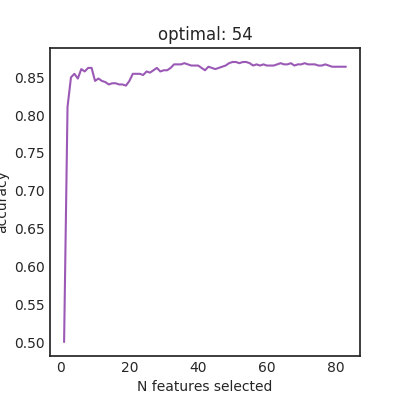

In [1006]:
# which is the best position?
class_name='position'
cX, cy, train_labels = group_by_class(sample_data, sample_labels, d.conditions, class_name=class_name)
cX = StandardScaler().fit_transform(cX)

print "Train data:", cX.shape
print "Train labels:", train_labels

dual = cX.shape[0] > cX.shape[1]
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1e9) #, C=self.clfparams['C_val'])

best_C = get_best_C(svc, cX, cy)

C = best_C

svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])

rfe = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds), scoring=scoring, n_jobs=1)
fit = rfe.fit(cX, cy)

best_score = fit.grid_scores_[fit.n_features_ - 1]
kept_rids = fit.get_support(indices=True)
nfeatures_best = len(kept_rids) #fit.n_features_
print "N features", nfeatures_best, fit.n_features_, fit.grid_scores_.shape
all_scores = fit.grid_scores_

fig = pl.figure(figsize=(4,4))
pl.plot(range(1, len(all_scores) + 1), all_scores)
pl.xlabel("N features selected")
pl.ylabel(scoring)
pl.title("optimal: %i" % len(kept_rids))

fit_best = True

if fit_best:
    roi_indices = kept_rids.copy()
else:
    roi_indices = np.arange(0, cX.shape[1])

    
xdata = cX[:, kept_rids]
xlabels = cy

dual = xdata.shape[0] > xdata.shape[1]
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=best_C) #, C=self.clfparams['C_val'])


In [1389]:
transforms

{'ori': [0.0, 90.0, 180.0, 270.0],
 'xpos': [0.0, 28.0, -14.0, -28.0, 14.0],
 'ypos': [-15.0, -5.0, 5.0, 15.0]}

In [1390]:
# Get list of configs with specified params:
class_name = 'ori'

#xpos = [14] # [-5]
#ypos = [5] #[0]
xpos = []
ypos = []

positions = list(set(d.conditions['position']))

transform_spanned = 'position' #'size' #'position'

test_transforms = ['0.0_5.0', '14.0_5.0'] #[7, 27] 
train_transforms = [p for p in positions if p not in test_transforms] # [17, 37] #[p for p in positions if p not in test_transforms]

yrot = [0]

# -------------------------------------------------------------------------
train_anchors = False
train_classes = sorted(list(set(d.conditions[class_name]))) #[0, 106]

if train_anchors:
    test_classes = [i for i in list(set(d.conditions[class_name])) if i not in train_classes]
else:
    test_classes = copy.copy(train_classes) #[0, 106]
    
print("train classes:", train_classes)
print("test classes:", test_classes)
# -------------------------------------------------------------------------

if 'yrot' in d.conditions.columns.tolist():
    sdf = d.conditions[(d.conditions['yrot'].isin(yrot))]
else:
    sdf = d.conditions.copy()

if len(xpos) > 0:
    sdf = sdf[(sdf['xpos'].isin(xpos))]
if len(ypos) > 0:
    sdf = sdf[(sdf['ypos'].isin(ypos))]

#
train_transform_subset = True
#train_sizes = [15, 45, 55]
#test_sizes = [25, 35]

# 
if train_transform_subset:
    train_sdf = sdf[sdf[transform_spanned].isin(train_transforms)]
    test_sdf = sdf[sdf[transform_spanned].isin(test_transforms)]
else:
    train_sdf = sdf.copy()
    test_sdf = sdf.copy()
    

train_configs = train_sdf[train_sdf[class_name].isin(train_classes)].index.tolist()
test_configs = test_sdf[test_sdf[class_name].isin(test_classes)].index.tolist()

print test_configs

('train classes:', [0.0, 90.0, 180.0, 270.0])
('test classes:', [0.0, 90.0, 180.0, 270.0])
['config011', 'config015', 'config031', 'config035', 'config051', 'config055', 'config071', 'config075']


In [1391]:
print train_configs

['config001', 'config002', 'config003', 'config004', 'config005', 'config006', 'config007', 'config008', 'config009', 'config010', 'config012', 'config013', 'config014', 'config016', 'config017', 'config018', 'config019', 'config020', 'config021', 'config022', 'config023', 'config024', 'config025', 'config026', 'config027', 'config028', 'config029', 'config030', 'config032', 'config033', 'config034', 'config036', 'config037', 'config038', 'config039', 'config040', 'config041', 'config042', 'config043', 'config044', 'config045', 'config046', 'config047', 'config048', 'config049', 'config050', 'config052', 'config053', 'config054', 'config056', 'config057', 'config058', 'config059', 'config060', 'config061', 'config062', 'config063', 'config064', 'config065', 'config066', 'config067', 'config068', 'config069', 'config070', 'config072', 'config073', 'config074', 'config076', 'config077', 'config078', 'config079', 'config080']


In [1394]:

trial_groups = d.labels.groupby('trial') #shape
train_indices = [int(trial[5:])-1 for trial, trialdf in trial_groups if trialdf['config'].isin(train_configs).all()]
test_indices =  [int(trial[5:])-1 for trial, trialdf in trial_groups if trialdf['config'].isin(test_configs).all()]

print("Total %i training trials." % (len(train_indices)))
print("Total %i testing trials." % (len(test_indices)))



Total 1440 training trials.
Total 160 testing trials.


In [1395]:
data_in = StandardScaler().fit_transform(sample_data)
print "All trials:", sample_data.shape
traindata = data_in[train_indices, :]
trainlabels = sample_labels[train_indices]

testdata = data_in[test_indices,:]
testlabels = sample_labels[test_indices]


All trials: (1600, 189)


In [1396]:
print traindata.shape
print trainlabels[0:5]

(1440, 189)
['config034' 'config028' 'config042' 'config047' 'config061']


In [1397]:
print "CLASS: %s" % class_name

cX, cy, train_labels = group_by_class(traindata, trainlabels, d.conditions, class_name=class_name)
print "Train data:", cX.shape
print "Train labels:", train_labels


test_cx, test_cy, test_labels = group_by_class(testdata, testlabels, d.conditions, class_name=class_name)
print "Test data:", test_cx.shape
print "Train labels:", test_labels



CLASS: ori
Train data: (1440, 189)
Train labels: [0.0, 90.0, 180.0, 270.0]
Test data: (160, 189)
Train labels: [0.0, 90.0, 180.0, 270.0]


# Model selection

In [1398]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, permutation_test_score, cross_val_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix


###### Find best C:

<IPython.core.display.Javascript object>


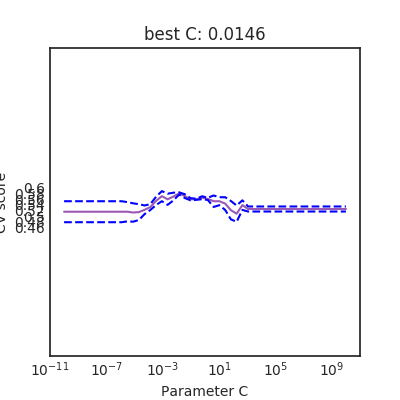

In [1330]:
test_with_rfe=False

if test_with_rfe:
    dual = cX[:, kept_rids].shape[0] > cX[:, kept_rids].shape[1]
else:
    dual = cX.shape[0] > cX.shape[1]
    
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1) #, C=self.clfparams['C_val'])

if test_with_rfe:
    bestC = get_best_C(svc, cX[:, kept_rids], cy)
else:
    bestC = get_best_C(svc, cX, cy)


##### RFE to find best features for decoding accuracy

In [ ]:
# Can find best features first (C=1, or biC or defaultC...), then go back and re-run bestC

bigC = 1e9
defaultC = 1.0

dual = cX.shape[0] > cX.shape[1]
print cX.shape
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=1) #, C=self.clfparams['C_val'])


rfe = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds), scoring=scoring, n_jobs=1)
fit = rfe.fit(cX, cy)

best_score = fit.grid_scores_[fit.n_features_ - 1]
kept_rids = fit.get_support(indices=True)
nfeatures_best = len(kept_rids) #fit.n_features_
print "N features", nfeatures_best, fit.n_features_, fit.grid_scores_.shape
all_scores = fit.grid_scores_


fig = pl.figure(figsize=(4,4))
pl.plot(range(1, len(all_scores) + 1), all_scores)
pl.xlabel("N features selected")
pl.ylabel(scoring)
pl.title("optimal: %i" % len(kept_rids))


(1440, 189)


In [1331]:

fit_best = True

if fit_best:
    roi_indices = kept_rids.copy()
else:
    roi_indices = np.arange(0, cX.shape[1])

    
xdata = StandardScaler().fit_transform(cX[:, kept_rids])
xlabels = cy


In [1332]:
C = best_C

dual = xdata.shape[0] > xdata.shape[1]
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=C) #, C=self.clfparams['C_val'])


In [1333]:
xdata_test = StandardScaler().fit_transform(test_cx[:, kept_rids])
xlabels_test = test_cy
    


In [1334]:
cy[0:5]

array([   0.,    0.,    0.,  106.,  106.])

# Cross-validation

In [1338]:
print "N folds (CV): %i" % cv_nfolds
cv_nfolds = 5
kfold = StratifiedKFold(n_splits=cv_nfolds, shuffle=True)
cv_results = cross_val_score(svc, xdata, xlabels, cv=kfold, scoring='accuracy')
print("CV RESULTS [%s]: %.3f (%.3f)" % (scoring, cv_results.mean(), cv_results.std()*2.)) # Print score and 95% CI of score estimate
print cv_results


N folds (CV): 5
CV RESULTS [accuracy]: 0.533 (0.022)
[ 0.54861111  0.54166667  0.52083333  0.53472222  0.52083333]


In [1348]:
permutation_test = True
n_permutations =  100
n_jobs = 1

if permutation_test:
    # -----------------------------------------------------------------------------
    # How significant is our classification score(s)?
    # Calculate p-value as percentage of runs for which obtained score is greater 
    # than the initial classification score (i.e., repeat classification after
    # randomizing and permuting labels).
    # -----------------------------------------------------------------------------
    score, permutation_scores, pvalue = permutation_test_score(
                                            svc, xdata, xlabels,
                                            scoring=scoring, 
                                            cv=kfold, 
                                            n_permutations=n_permutations, 
                                            n_jobs=n_jobs)

    print("Classification score %s (pvalue : %s)" % (score, pvalue))


Classification score 0.534722222222 (pvalue : 0.0792079207921)


<IPython.core.display.Javascript object>


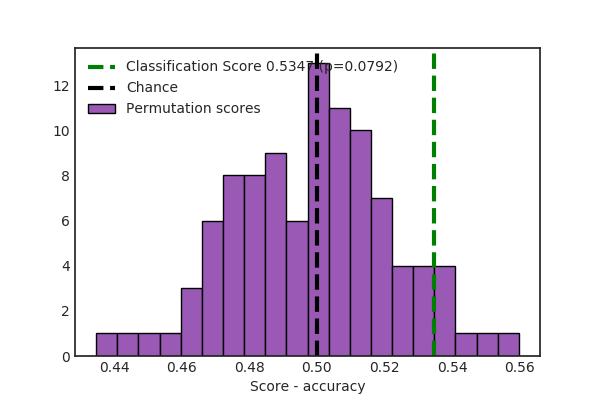

In [1349]:
if permutation_test:
    
    # View histogram of permutation scores            
    fig = pl.figure(figsize=(6,4))
    n_classes = np.unique([cy]).size

    pl.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
    ylim = pl.ylim()
    pl.plot(2 * [score], ylim, '--g', linewidth=3, label='Classification Score %.4f (p=%.4f)' % (score, pvalue))
    pl.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance')
    pl.ylim(ylim)
    pl.legend()
    pl.xlabel('Score - %s' % scoring)
            

In [1346]:
print("Getting cv folds for confusion matrix (labels: %s)" % str(train_labels))

loo = cross_validation.StratifiedKFold(xlabels, n_folds=cv_nfolds, shuffle=True)
predicted = []
true = []
cv_train_ixs = [] 
cv_test_ixs = []
for train, test in loo: #, groups=groups):
    #print train, test
    cv_train, cv_test = xdata[train,:], xdata[test,:]
    cv_train_labels, cv_test_labels = xlabels[train], xlabels[test]
    
    y_pred = svc.fit(cv_train, cv_train_labels).predict(cv_test)
    
    predicted.append(y_pred)
    true.append(cv_test_labels)
    cv_train_ixs.append(train)
    cv_test_ixs.append(test)
    


Getting cv folds for confusion matrix (labels: [0.0, 106.0])


Normalized confusion matrix


<IPython.core.display.Javascript object>


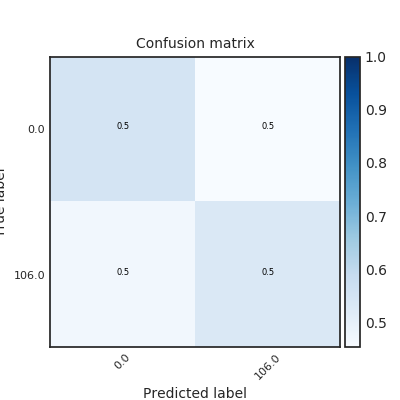

In [1350]:
if not isinstance(predicted[0], (int, float, str)) and len(predicted[0]) > 1:
    cmatrix = confusion_matrix(true[0], predicted[0], labels=train_labels)
    for iter_idx in range(len(predicted))[1:]:
        #print "adding iter %i" % iter_idx
        cmatrix += confusion_matrix(true[iter_idx], predicted[iter_idx], labels=train_labels)
    conf_mat_str = 'AVG'
    
plot_confusion_matrix(cmatrix, train_labels, normalize=True)

###### Look at CV accuracy by stimulus condition:

In [1352]:
config_sorter = 'position'

sort_configs = list(set([d.conditions.loc[cfg][config_sorter] for cfg in trainlabels]))
print sort_configs

print trainlabels.shape
print xdata.shape

['0.0_-5.0', '-14.0_-5.0', '-14.0_-15.0', '14.0_-5.0', '-28.0_-5.0', '14.0_-15.0', '28.0_-15.0', '0.0_15.0', '28.0_-5.0', '-14.0_15.0', '-28.0_-15.0', '28.0_5.0', '-14.0_5.0', '14.0_15.0', '28.0_15.0', '-28.0_15.0', '-28.0_5.0', '0.0_-15.0']
(720,)
(720, 142)


In [1353]:
results_by_config = {}

# Sort CV results by config_sorter (even if trained class is different):

for fold, (pred,tru,ixs) in enumerate(zip(predicted, true, cv_test_ixs)):
    corresp_configs = trainlabels[ixs]
    configs_tested = list(set(corresp_configs))
    results_by_config[fold] = {}
    for cfg in configs_tested:
        curr_sort_value = d.conditions.loc[cfg][config_sorter]
        if curr_sort_value not in results_by_config[fold].keys():
            results_by_config[fold][curr_sort_value] = []
            
        fold_ixs = [i for i, c in enumerate(corresp_configs) if c==cfg]
        ncorrect = [1 if p==t else 0 for p, t in zip(pred[fold_ixs], tru[fold_ixs])]
        results_by_config[fold][curr_sort_value].extend(ncorrect)
        results_by_config[fold][curr_sort_value].extend(ncorrect)
        

In [1354]:
average_scores_by_config = {}; sem_scores_by_config={};

for sort_value in sort_configs:
    average_scores_by_config[sort_value] = np.mean([np.mean(results_by_config[k][sort_value]) for k in range(cv_nfolds)])
    sem_scores_by_config[sort_value] = stats.sem([np.mean(results_by_config[k][sort_value]) for k in range(cv_nfolds)])
average_scores_by_config


{'-14.0_-15.0': 0.63928571428571423,
 '-14.0_-5.0': 0.54285714285714293,
 '-14.0_15.0': 0.52357142857142858,
 '-14.0_5.0': 0.47857142857142854,
 '-28.0_-15.0': 0.58571428571428563,
 '-28.0_-5.0': 0.46303030303030307,
 '-28.0_15.0': 0.51327672327672336,
 '-28.0_5.0': 0.53003663003662993,
 '0.0_-15.0': 0.67217948717948717,
 '0.0_-5.0': 0.51238095238095238,
 '0.0_15.0': 0.60650793650793655,
 '14.0_-15.0': 0.48571428571428577,
 '14.0_-5.0': 0.52020202020202022,
 '14.0_15.0': 0.64769230769230768,
 '28.0_-15.0': 0.47853535353535354,
 '28.0_-5.0': 0.4175757575757576,
 '28.0_15.0': 0.56031746031746033,
 '28.0_5.0': 0.53055555555555556}

<IPython.core.display.Javascript object>


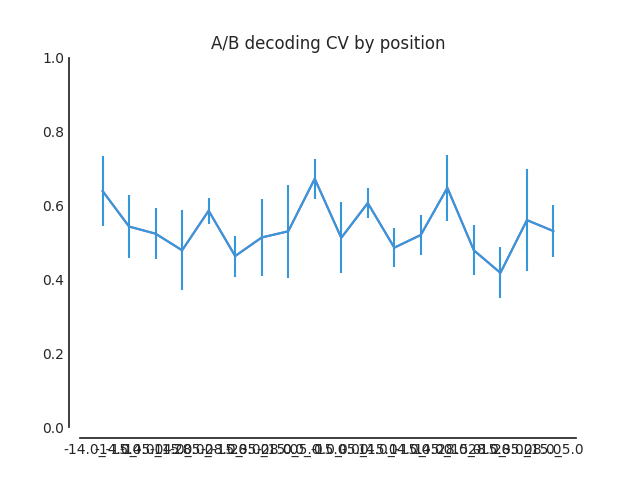

In [1355]:
pl.figure()
x = sorted(average_scores_by_config.keys())
y = [v for k, v in sorted(average_scores_by_config.items(), key=lambda x: x[0])]
yerr = [v for k, v in sorted(sem_scores_by_config.items(), key=lambda x: x[0])]
pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)
pl.ylim([0, 1])
pl.title("A/B decoding CV by %s" % config_sorter)
sns.despine(offset=8)

In [1357]:
if config_sorter == 'position':
    xvals = list(set([float(pos.split('_')[0]) for pos in positions]))
    yvals = list(set([float(pos.split('_')[1]) for pos in positions]))
    print "%i xvals, %i yvals" % (len(xvals), len(yvals))
    nxpos = len(xvals)
    nypos = len(yvals)
    accuracy_grid = np.empty((nypos, nxpos))

    accuracy_grid

5 xvals, 4 yvals


0.0_5.0
14.0_5.0


<IPython.core.display.Javascript object>


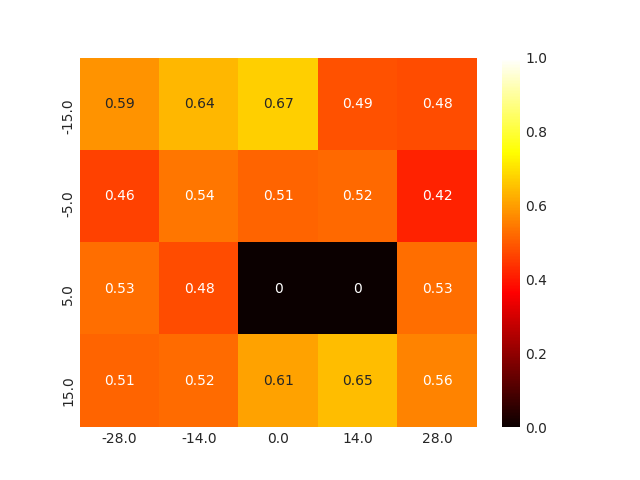

In [1376]:
if config_sorter == 'position':

    for yi, y in enumerate(sorted(yvals)):
        for xi, x in enumerate(sorted(xvals)):
            pos_str = '%.1f_%.1f' % (x, y)
            if pos_str not in average_scores_by_config.keys():
                print pos_str
                score = 0
            else:
                score = average_scores_by_config[pos_str]
            accuracy_grid[yi, xi] = score

    fig, ax = pl.subplots() #pl.figure()
    sns.heatmap(accuracy_grid, vmin=0, vmax=1, ax=ax, cmap="hot",
                annot=True, xticklabels=sorted(xvals), yticklabels=sorted(yvals))
    # ax.set_xticks(np.arange(nxpos))
    # ax.set_xticklabels([str(i) for i in xpos])

    # ax.set_yticks(np.arange(nypos))
    # ax.set_yticklabels([str(i) for i in ypos])

    # pl.colorbar()

# Train classifier

In [1360]:
svc = LinearSVC(random_state=0, dual=dual, multi_class='ovr', C=best_C) #, C=self.clfparams['C_val'])
svc.fit(xdata, xlabels)


LinearSVC(C=1.2067926406393288e-06, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

In [1361]:
# Test samples:

predictions = svc.predict(xdata_test)


In [1362]:
print predictions.shape
print xlabels_test.shape

print list(set(xlabels_test))

(80,)
(80,)
[0.0, 106.0]


In [1363]:
correct_choices = [1 if p==t else 0 for p, t in zip(predictions, xlabels_test)]
print np.mean(correct_choices)

0.525


In [1364]:
print testlabels.shape
print list(set(testlabels))

(80,)
['config011', 'config031', 'config015', 'config035']


In [1365]:
test_counts_by_config = {}
for cfg in list(set(testlabels)):
    curr_value = d.conditions.loc[cfg][config_sorter]
    
    curr_indices = np.where(testlabels==cfg) # index into predictions and "class labeled" test_labels
    correct = [1 if p==t else 0 for p, t in zip(predictions[curr_indices], xlabels_test[curr_indices])]
    if curr_value not in test_counts_by_config.keys():
        test_counts_by_config[curr_value] = []
        
    test_counts_by_config[curr_value].extend(correct)

In [1366]:
test_counts_by_config.keys()

['0.0_5.0', '14.0_5.0']

In [1367]:
print "Train transform values:", average_scores_by_config.keys()
print "Test transform values:", test_transforms


Train transform values: ['0.0_-5.0', '-14.0_-15.0', '14.0_-5.0', '-28.0_-5.0', '14.0_-15.0', '28.0_-15.0', '0.0_15.0', '28.0_-5.0', '-14.0_15.0', '-28.0_-15.0', '-14.0_-5.0', '-14.0_5.0', '14.0_15.0', '28.0_15.0', '0.0_-15.0', '-28.0_15.0', '-28.0_5.0', '28.0_5.0']
Test transform values: ['0.0_5.0', '14.0_5.0']


In [1368]:
test_scores = {}
for tlabel in test_transforms:
    test_scores[tlabel] = np.mean(test_counts_by_config[tlabel])

print test_scores

{'0.0_5.0': 0.45000000000000001, '14.0_5.0': 0.59999999999999998}


0.0_5.0
14.0_5.0


<IPython.core.display.Javascript object>


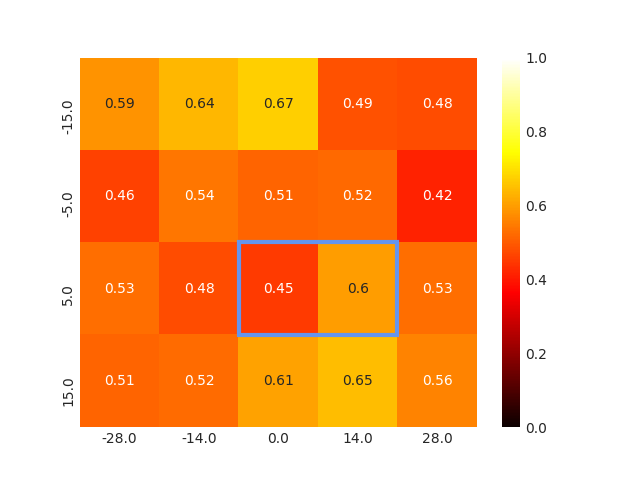

In [1370]:
from matplotlib.patches import Rectangle

if config_sorter == 'position':
    for yi, y in enumerate(sorted(yvals)):
        for xi, x in enumerate(sorted(xvals)):
            pos_str = '%.1f_%.1f' % (x, y)
            if pos_str not in average_scores_by_config.keys():
                print pos_str
                score = test_scores[pos_str]
            else:
                score = average_scores_by_config[pos_str]
            accuracy_grid[yi, xi] = score

    fig, ax = pl.subplots() #pl.figure()
    sns.heatmap(accuracy_grid, vmin=0, vmax=1, ax=ax, cmap="hot",
                annot=True, xticklabels=sorted(xvals), yticklabels=sorted(yvals))
    
    ypos_test = list(set([float(pos.split('_')[1]) for pos in test_scores.keys()]))
    xpos_test = list(set([float(pos.split('_')[0]) for pos in test_scores.keys()]))
    
    test_box_x = [sorted(xvals).index(tx) for tx in xpos_test][0]
    test_box_y = [sorted(yvals).index(ty) for ty in ypos_test][0]
    ax.add_patch(Rectangle((test_box_x, test_box_y), len(xpos_test), len(ypos_test), fill=False, 
                           edgecolor='cornflowerblue', lw=3))


In [1270]:
chance_level

0.25

<IPython.core.display.Javascript object>


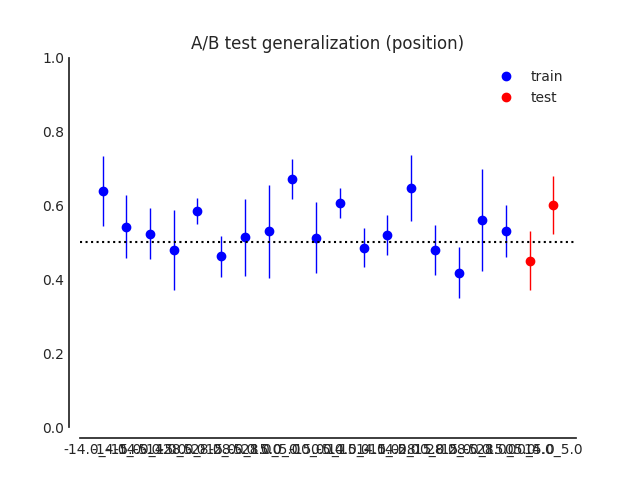

In [1371]:
fig, ax = pl.subplots() #pl.figure()
x = sorted(average_scores_by_config.keys())
y = [v for k, v in sorted(average_scores_by_config.items(), key=lambda x: x[0])]

yerr = [v for k, v in sorted(sem_scores_by_config.items(), key=lambda x: x[0])]

ax.plot(x, y, marker='o', markerfacecolor='b', markeredgecolor='b', linestyle='None', label='train')
ax.errorbar(x=x, y=y, yerr=yerr, ecolor='b', elinewidth=1, linestyle='None')


test_x = sorted(test_counts_by_config.keys())
test_y = [np.mean(vals) for k, vals in sorted(test_counts_by_config.items(), key=lambda x:x[0])]
test_yerr = [stats.sem(vals) for k, vals in sorted(test_counts_by_config.items(), key=lambda x:x[0])]
ax.plot(test_x, test_y, marker='o', markerfacecolor='r', markeredgecolor='r', linestyle='None', label='test')
ax.errorbar(x=test_x, y=test_y, yerr=test_yerr, ecolor='r', elinewidth=1, linestyle='None')

pl.ylim([0, 1])
pl.title("A/B test generalization (%s)" % config_sorter)
sns.despine(offset=8)
pl.legend()

chance_level = 1./len(train_labels)
ax.axhline(y=chance_level, color='k', linestyle=':')

In [1375]:
D.source

'/n/coxfs01/2p-data/JC031/20181118/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_e15b1d_traces001_f8116d_traces001_06a892_traces001_d71691/data_arrays/datasets.npz'

In [752]:
choices = {}
for test_value in test_labels:
    print test_value
    curr_indices = np.where(xlabels_test==test_value)[0]
    choices[test_value] = predictions[curr_indices]
choices

0.0
106.0


{0.0: array([ 106.,  106.,  106.,    0.,  106.,  106.,    0.,  106.,  106.,
         106.,    0.,  106.,    0.,    0.,    0.,    0.,  106.,  106.,
         106.,  106.,    0.,  106.,    0.,    0.,  106.,  106.,  106.,
           0.,  106.,  106.,    0.,    0.,    0.,  106.,    0.,    0.,
         106.,    0.,  106.,  106.]),
 106.0: array([ 106.,  106.,  106.,  106.,  106.,    0.,  106.,  106.,    0.,
           0.,  106.,  106.,  106.,  106.,    0.,    0.,  106.,    0.,
         106.,    0.,  106.,    0.,    0.,  106.,  106.,  106.,    0.,
           0.,  106.,    0.,    0.,    0.,  106.,  106.,    0.,  106.,
           0.,  106.,  106.,  106.])}

In [596]:
import scipy.stats as stats

In [597]:
all_morph_levels = sorted(list(set(d.conditions['morphlevel'])))
print all_morph_levels
pchoose100 = {}; pchoose100_sem = {};

for morph in all_morph_levels:
    if morph in train_labels:
        mean_cv = []
        for pred, tru in zip(predicted, true):
            curr_trials = np.where(tru==morph)[0]
            mean_cv.append(np.mean([1 if p==106 else 0 for p in pred[curr_trials]]))
        pchoose100[morph] = np.mean(mean_cv)
        pchoose100_sem[morph] = stats.sem(mean_cv)
    else:
        pchoose100[morph] = np.mean([1 if p==106 else 0 for p in choices[morph]])
        pchoose100_sem[morph] = stats.sem([1 if p==106 else 0 for p in choices[morph]])

pchoose100

[0.0, 27, 53, 79, 106]


{0.0: 0.10000000000000001,
 27: 0.59999999999999998,
 53: 0.90000000000000002,
 79: 0.59999999999999998,
 106: 1.0}

In [598]:
mean_cv

[1.0, 1.0, 1.0, 1.0, 1.0]

<IPython.core.display.Javascript object>


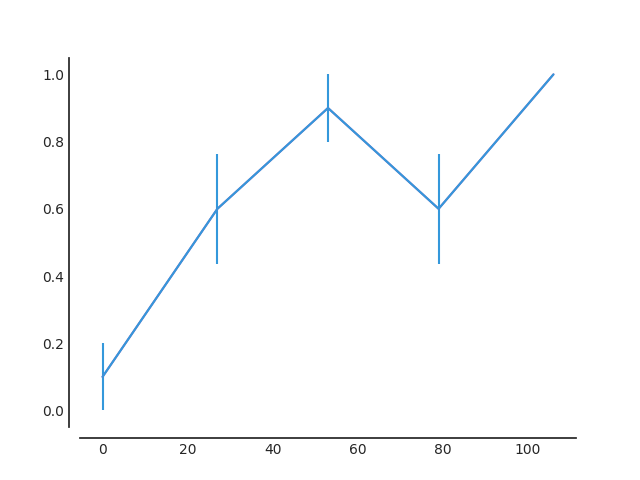

[0.10000000000000002, 0.16329931618554519, 0.099999999999999992, 0.16329931618554522, 0.0]


In [599]:
pl.figure()
x = sorted(all_morph_levels)
y = [v for k, v in sorted(pchoose100.items(), key=lambda x: x[0])]
yerr = [v for k, v in sorted(pchoose100_sem.items(), key=lambda x: x[0])]
print yerr
pl.plot(x, y)
pl.errorbar(x=x, y=y, yerr=yerr)
sns.despine(offset = 8)

In [35]:
test_data = clf.train_results['test_data']
test_labels = clf.train_results['test_labels']
test_labels_config_names = clf.cy_labels[np.array(clf.train_results['test_labels'].index.tolist())]

In [37]:
test_results = clf.test_classifier(test_data=test_data, 
                                test_labels=test_labels, 
                                config_labels=test_labels_config_names, 
                                include_cv=False)
                
curr_output_dir = clf.classifier_dir

In [43]:
test_results.keys()

['test_labels',
 'results_by_class',
 'predicted_classes',
 'results_by_config',
 'test_data',
 'config_labels']

In [44]:
test_results['results_by_config']

{'config001': {'indices': array([  7,  47,  48,  78,  86, 119, 130]),
  'predicted': array([ 55.,  55.,  45.,  15.,  35.,  15.,  55.]),
  'true': 7       NaN
  47      NaN
  48     25.0
  78      NaN
  86      NaN
  119     NaN
  130     NaN
  dtype: float64},
 'config002': {'indices': array([ 72, 100, 142, 151]),
  'predicted': array([ 45.,  35.,  45.,  45.]),
  'true': 72      NaN
  100     NaN
  142    25.0
  151     NaN
  dtype: float64},
 'config003': {'indices': array([ 36, 122]),
  'predicted': array([ 15.,  15.]),
  'true': 36      NaN
  122    15.0
  dtype: float64},
 'config004': {'indices': array([ 16,  31, 103, 112]),
  'predicted': array([ 55.,  55.,  45.,  35.]),
  'true': 16      NaN
  31     35.0
  103    15.0
  112     NaN
  dtype: float64},
 'config005': {'indices': array([  4,  43,  45,  70, 152, 155]),
  'predicted': array([ 15.,  55.,  35.,  45.,  35.,  55.]),
  'true': 4     NaN
  43    NaN
  45    NaN
  70    NaN
  152   NaN
  155   NaN
  dtype: float64},
 'confi